In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np

In [3]:
with open("../../../data/caprice/caprice_seq_data_20210430.pkl", "rb") as fin:
    data = pickle.load(fin)

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_path = "../../../data/caprice/seq-model-ep9"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Microsoft JhengHei"

In [6]:
import shap

In [7]:
from transformers import pipeline
caprice_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [8]:
explainer = shap.Explainer(caprice_pipeline, algorithm="partition")

In [9]:
_masker = explainer.masker

In [10]:
import torch
from DistilTag import DistilTag
tagger = DistilTag()

In [11]:
tagger.tag("我才不要去辦吃到飽")

[[('我', 'Nh'),
  ('才', 'Da'),
  ('不要', 'D'),
  ('去', 'D'),
  ('辦', 'VC'),
  ('吃', 'VC'),
  ('到', 'P'),
  ('飽', 'VH')]]

In [15]:
txt = "中華499很高貴"
shap_values = explainer([txt])
_masker = explainer.masker
_masker._segments_s

array(['', '中', '華', '499', '很', '高', '貴', ''], dtype='<U3')

In [83]:
np.concatenate([np.arange(0,2), np.arange(3,4)])

array([0, 1, 3])

In [105]:
import re
from itertools import chain
import unicodedata as ud
from scipy.cluster.hierarchy import linkage, dendrogram
import torch
from icecream import ic

def custom_clustering(inst, s, pat):
    inst._update_s_cache(s)
    out = tagger.soft_tag(s)
    wlogits = torch.cat(out[0])
    tokens = inst._segments_s    
    out_tokens = list(chain(*out[2]))
    wprobs = torch.softmax(wlogits, axis=1).numpy()[:,0]    
    p_wb_tokens = np.ones(len(tokens))
    
    cur = [0, 0]
    buf = ""    
    align_tokens = []
    align_s2t = [(0,0)] * len(tokens)
    align_t2s = np.ones(len(out_tokens)+1, dtype=np.int32) * (len(tokens)-1)
    for token_i, token_s in enumerate(inst._segments_s):
        if token_s == '':
            # ic("skip empty token")
            continue
        while cur[1] < len(out_tokens):
            token_t = ud.normalize("NFKC", out_tokens[cur[1]])
            buf += token_t            
            # ic(token_s, buf)
            if buf == token_s:
                p_wb_tokens[token_i] = wprobs[cur[0]:cur[1]+1].max()
                align_tokens.append(buf)
                align_s2t[token_i] = (cur[0], cur[1]+1)
                align_t2s[cur[0]:cur[1]+1] = token_i
                buf = ''            
                cur = [cur[1]+1, cur[1]+1]
                break
            else:
                cur = [cur[0], cur[1]+1]
    
    if buf:
        align_tokens.append(buf)
        align_s2t[token_i] = (cur[0], cur[1]+1)
        align_t2s[cur[0]:cur[1]+1] = token_i
    
    mat = re.search(pat, s)    
    pat_spans = []
    if mat:
        pat_spans = [mat.span(x) for x in range(1, len(mat.groups())+1)]
    
    def in_pat(s_idx):        
        t_span = align_s2t[s_idx]            
        if t_span[0] == t_span[1]:
            # reject empty span
            return False
        
        for pat_x in pat_spans:
            if t_span[0] >= pat_x[0] and t_span[1] <= pat_x[1]:
                return (align_t2s[pat_x[0]], align_t2s[pat_x[1]])
        return ()
    
    def token_dist(x, y): 
        x = int(x); y = int(y)
        x = min(x, y); y = max(x, y)
        # word boundary distance is the word probability of the following character,
        # therefore a plus one offset.        
        span_x = in_pat(x)
        span_y = in_pat(y)
        if span_x and span_y and span_x != span_y:
            ic(x, span_x, y, span_y)
            x_start = min(x+1, span_x[1])
            x_end = span_x[1]
            x_rng = np.arange(x_start, x_end)
            y_start = min(span_y[0]+1, span_y[1])
            y_end = min(y+1, span_y[1])
            y_rng = np.arange(y_start, y_end)
            rng = np.concatenate([x_rng, y_rng])
            ic(rng)
            dist = p_wb_tokens[rng].sum()            
            # dist = p_wb_tokens[x+1:y+1].sum()
        elif span_x and span_x == span_y:
            span_length = span_x[1] - span_x[0]
            dist = p_wb_tokens[x+1:y+1].sum() / span_length
        else:
            dist = p_wb_tokens[x+1:y+1].sum()
        return dist
        
    # ic(align_s2t)
    # ic(align_t2s)
    # ic(p_wb_tokens)
    # ic(pat_spans)
    inX = np.arange(len(tokens)).reshape(-1, 1)
    Z = linkage(inX, metric=token_dist)
    return Z

In [106]:
_masker._segments_s

array(['', '中', '華', '499', '很', '高', '貴', ''], dtype='<U3')

In [107]:
Z = custom_clustering(_masker, txt, "(中華).+(高貴)")
Z

ic| x: 1, span_x: (1, 3), y: 5, span_y: (5, 7)
ic| rng: array([2])
ic| x: 1, span_x: (1, 3), y: 6, span_y: (5, 7)
ic| rng: array([2, 6])
ic| x: 2, span_x: (1, 3), y: 5, span_y: (5, 7)
ic| rng: array([], dtype=int32)
ic| x: 2, span_x: (1, 3), y: 6, span_y: (5, 7)
ic| rng: array([6])


array([[ 2.        ,  5.        ,  0.        ,  2.        ],
       [ 6.        ,  8.        ,  0.10648768,  3.        ],
       [ 1.        ,  9.        ,  0.14180239,  4.        ],
       [ 3.        , 10.        ,  0.6433751 ,  5.        ],
       [ 0.        , 11.        ,  0.64398599,  6.        ],
       [ 4.        , 12.        ,  0.64669418,  7.        ],
       [ 7.        , 13.        ,  1.        ,  8.        ]])

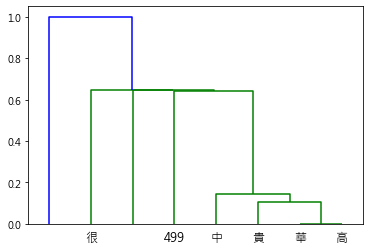

In [108]:
dendrogram(Z, labels=_masker._segments_s);

In [110]:
from types import MethodType
from functools import partial
clustering_wrapper = partial(custom_clustering, pat="(到一個)")
explainer.masker.clustering = MethodType(clustering_wrapper, explainer.masker)

In [111]:
shap_values = explainer(["他貴到一個爆炸"])

In [114]:
shap_values.clustering

array([[[ 4.        ,  5.        ,  0.12327712,  2.        ],
        [ 3.        ,  9.        ,  0.1359199 ,  3.        ],
        [ 6.        ,  7.        ,  0.17089015,  2.        ],
        [ 2.        , 10.        ,  0.3227866 ,  4.        ],
        [11.        , 12.        ,  0.63041621,  6.        ],
        [ 0.        ,  1.        ,  0.64684439,  2.        ],
        [13.        , 14.        ,  0.75969934,  8.        ],
        [ 8.        , 15.        ,  1.        ,  9.        ]]])

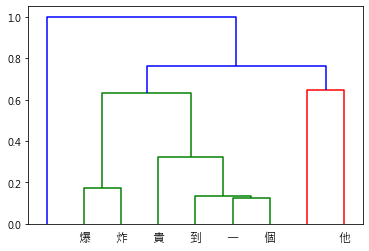

In [115]:
dendrogram(shap_values.clustering[0], labels=_masker._segments_s);

In [112]:
shap.plots.text(shap_values[0, :, 1])

## Fluid DistilSeg

In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
import DistilTag

In [58]:
tagger = DistilTag.DistilTag()

In [147]:
txt = "消失在人海盡頭"
out = tagger.tag(txt, return_logits=True)
logits = out[1]
tokens = out[2]
out[0]

[[('消失', 'VA'), ('在', 'P'), ('人海', 'Na'), ('盡頭', 'Ncd')]]

In [148]:
out = tagger.soft_tag(txt)

In [166]:
tagger.print_soft_tag(*out, Tw=2, Tp=2)

消_0.69  VA_0.98/ VH_0.00/ Na_0.00/ Nv_0.00/ Nd_0.00
失_0.23  VA_0.98/VAC_0.00/ Na_0.00/ VH_0.00/ Nv_0.00
在_0.54 VCL_0.71/  P_0.08/ VG_0.04/Caa_0.02/ VJ_0.01
人_0.70  Na_0.57/ Nc_0.38/ Nb_0.01/ VH_0.01/ Nh_0.01
海_0.27  Na_0.97/ Nc_0.03/ VH_0.00/ Nb_0.00/ VA_0.00
盡_0.49 Ncd_0.98/ Nc_0.01/ Ng_0.00/Nep_0.00/ VH_0.00
頭_0.31 Ncd_0.99/ Nc_0.00/ Ng_0.00/ Na_0.00/Neq_0.00



In [165]:
print("0.50", tagger.decode_soft_tag(*out, Tw=1, Tp=1, wcut=0.5))

0.50 [[('消失', 'VA'), ('在', 'VCL'), ('人海盡頭', 'Ncd')]]


In [163]:
for wcut in np.arange(0, 1, 0.1):
    print(f"{wcut:.2f}", tagger.decode_soft_tag(*out, Tw=2, Tp=1, wcut=wcut))

0.00 [[('消', 'VA'), ('失', 'VA'), ('在', 'VCL'), ('人', 'Na'), ('海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.10 [[('消', 'VA'), ('失', 'VA'), ('在', 'VCL'), ('人', 'Na'), ('海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.20 [[('消', 'VA'), ('失', 'VA'), ('在', 'VCL'), ('人', 'Na'), ('海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.30 [[('消', 'VA'), ('失', 'VA'), ('在', 'VCL'), ('人', 'Na'), ('海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.40 [[('消失', 'VA'), ('在', 'VCL'), ('人海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.50 [[('消失', 'VA'), ('在', 'VCL'), ('人海盡頭', 'Ncd')]]
0.60 [[('消失在', 'VA'), ('人海盡頭', 'Ncd')]]
0.70 [[('消失在人海盡頭', 'Ncd')]]
0.80 [[('消失在人海盡頭', 'Ncd')]]
0.90 [[('消失在人海盡頭', 'Ncd')]]


In [167]:
for wcut in np.arange(0, 1, 0.1):
    print(f"{wcut:.2f}", tagger.decode_soft_tag(*out, Tw=1, Tp=5, wcut=wcut))

0.00 [[('消', 'VA'), ('失', 'VA'), ('在', 'VCL'), ('人', 'Na'), ('海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.10 [[('消', 'VA'), ('失', 'VA'), ('在', 'VCL'), ('人', 'Na'), ('海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.20 [[('消', 'VA'), ('失', 'VA'), ('在', 'VCL'), ('人', 'Na'), ('海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.30 [[('消失', 'VA'), ('在', 'VCL'), ('人海', 'Na'), ('盡', 'Ncd'), ('頭', 'Ncd')]]
0.40 [[('消失', 'VA'), ('在', 'VCL'), ('人海', 'Na'), ('盡頭', 'Ncd')]]
0.50 [[('消失', 'VA'), ('在', 'VCL'), ('人海盡頭', 'Na')]]
0.60 [[('消失在', 'VA'), ('人海盡頭', 'Na')]]
0.70 [[('消失在人海盡頭', 'Na')]]
0.80 [[('消失在人海盡頭', 'Na')]]
0.90 [[('消失在人海盡頭', 'Na')]]
